In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


In [2]:
np.random.seed(42)
n_engines = 100
max_cycles = 300
data = []

for engine_id in range(1, n_engines+1):
    engine_life = np.random.randint(100, max_cycles)
    for cycle in range(1, engine_life+1):
        degradation_factor = cycle / engine_life
        op_setting_1 = np.random.normal(-0.0007, 0.0005) + degradation_factor * 0.001
        op_setting_2 = np.random.normal(-0.0004, 0.0003) + degradation_factor * 0.0008
        op_setting_3 = np.random.normal(100, 1) + degradation_factor * 2
        sensors = []
        for _ in range(21):
            base_value = np.random.normal(500, 50)
            noise = np.random.normal(0, 10)
            degradation = degradation_factor * np.random.normal(20, 5)
            sensors.append(base_value + noise + degradation)
        rul = engine_life - cycle
        row = [engine_id, cycle, op_setting_1, op_setting_2, op_setting_3] + sensors + [rul]
        data.append(row)

columns = ['engine_id', 'cycle'] + [f'op_setting_{i}' for i in range(1,4)] + [f'sensor_{i}' for i in range(1,22)] + ['RUL']
df = pd.DataFrame(data, columns=columns)
df.head()


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.000970,-0.000241,100.483762,559.350175,394.632548,454.434146,496.919008,496.427015,...,567.123390,466.645382,635.575013,523.961684,527.727228,495.130471,469.640081,536.773437,510.501898,201
1,1,2,-0.000813,-0.000623,101.231974,546.162889,408.625452,533.276151,428.351144,566.228264,...,450.452649,595.875536,454.470876,408.254675,506.955725,466.852633,516.630314,582.408030,595.862712,200
2,1,3,-0.000792,-0.000595,100.757536,472.903535,557.272090,538.552771,488.102570,447.443267,...,495.573273,419.420023,416.745798,496.186603,453.415626,502.506488,512.930595,503.847935,556.808808,199
3,1,4,-0.000255,-0.000266,100.034908,436.693213,408.834540,524.482578,621.711706,469.265958,...,561.977350,499.409575,486.937829,468.682008,508.235496,466.095015,451.002996,515.579137,528.247263,198
4,1,5,-0.000632,-0.000558,99.369501,484.443459,484.261890,472.395691,660.808727,581.274105,...,404.408381,521.865815,588.886518,473.621692,426.059898,527.500564,546.074293,376.827095,481.588868,197


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19544 entries, 0 to 19543
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   engine_id     19544 non-null  int64  
 1   cycle         19544 non-null  int64  
 2   op_setting_1  19544 non-null  float64
 3   op_setting_2  19544 non-null  float64
 4   op_setting_3  19544 non-null  float64
 5   sensor_1      19544 non-null  float64
 6   sensor_2      19544 non-null  float64
 7   sensor_3      19544 non-null  float64
 8   sensor_4      19544 non-null  float64
 9   sensor_5      19544 non-null  float64
 10  sensor_6      19544 non-null  float64
 11  sensor_7      19544 non-null  float64
 12  sensor_8      19544 non-null  float64
 13  sensor_9      19544 non-null  float64
 14  sensor_10     19544 non-null  float64
 15  sensor_11     19544 non-null  float64
 16  sensor_12     19544 non-null  float64
 17  sensor_13     19544 non-null  float64
 18  sensor_14     19544 non-nu

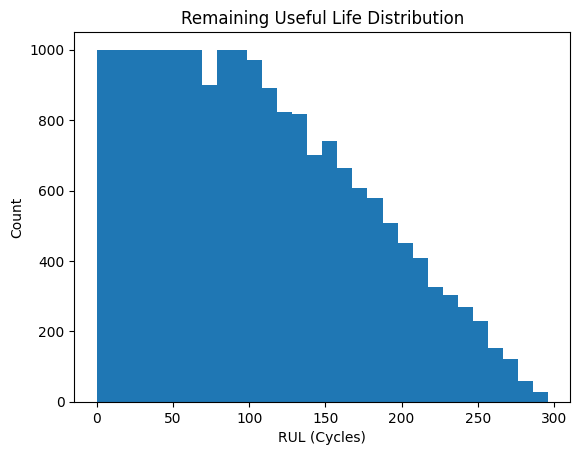

In [3]:
print(df.info())
print(df.describe())
print(df.isnull().sum())
print(f"Unique engines: {df['engine_id'].nunique()}")
print(f"Average engine life: {df.groupby('engine_id')['cycle'].max().mean():.1f} cycles")
plt.hist(df['RUL'], bins=30)
plt.title("Remaining Useful Life Distribution")
plt.xlabel("RUL (Cycles)")
plt.ylabel("Count")
plt.show()


In [4]:
df_processed = df.copy()
sensor_cols = [col for col in df.columns if 'sensor_' in col]
# Rolling averages for first 5 sensors
for sensor in sensor_cols[:5]:
    df_processed[f'{sensor}_rolling_mean'] = df_processed.groupby('engine_id')[sensor].rolling(window=5, min_periods=1).mean().reset_index(0, drop=True)
# Degradation indicators
df_processed['cycle_norm'] = df_processed.groupby('engine_id')['cycle'].transform(lambda x: x/x.max())
df_processed['cycles_since_start'] = df_processed['cycle']
# Lag features
for sensor in sensor_cols[:3]:
    df_processed[f'{sensor}_lag1'] = df_processed.groupby('engine_id')[sensor].shift(1)
df_processed = df_processed.fillna(method='bfill').fillna(method='ffill')
feature_cols = [col for col in df_processed.columns if col not in ['engine_id', 'cycle', 'RUL']]


In [5]:
X = df_processed[feature_cols]
y = df_processed['RUL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_test_lr = lr_model.predict(X_test_scaled)

rf_model = RandomForestRegressor(n_estimators=20, max_depth=8, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_test_rf = rf_model.predict(X_test)

results = {
    'Linear Regression': {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test_lr)),
        'R2': r2_score(y_test, y_pred_test_lr),
        'MAE': mean_absolute_error(y_test, y_pred_test_lr)
    },
    'Random Forest': {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test_rf)),
        'R2': r2_score(y_test, y_pred_test_rf),
        'MAE': mean_absolute_error(y_test, y_pred_test_rf)
    }
}
print(results)


{'Linear Regression': {'RMSE': np.float64(28.144000414675734), 'R2': 0.8348758782056683, 'MAE': 19.86786512838816}, 'Random Forest': {'RMSE': np.float64(12.18724950306356), 'R2': 0.9690364841296957, 'MAE': 4.773066825387999}}


In [7]:
feat_imp = pd.DataFrame({'Feature': feature_cols, 'Importance': rf_model.feature_importances_})
feat_imp.sort_values('Importance', ascending=False).head(10)


,Feature,Importance
29,cycle_norm,0.878434
30,cycles_since_start,0.121215
26,sensor_3_rolling_mean,0.000144
31,sensor_1_lag1,0.000041
5,sensor_3,0.000019
28,sensor_5_rolling_mean,0.000017
21,sensor_19,0.000015
24,sensor_1_rolling_mean,0.000012
12,sensor_10,0.000009
13,sensor_11,0.000008


In [8]:
def predict_engine_rul(engine_data, model, scaler=None, feature_columns=None):
    if feature_columns:
        engine_data = engine_data[feature_columns]
    if scaler is not None:
        engine_data = scaler.transform(engine_data)
    prediction = model.predict(engine_data)
    return prediction[0] if len(prediction) == 1 else prediction

# Example:
sample_engine_data = X_test.iloc[[0]]
print("Predicted RUL:", predict_engine_rul(sample_engine_data, rf_model, feature_columns=feature_cols))
print("Actual RUL:", y_test.iloc[0])


Predicted RUL: 26.288075002186996
Actual RUL: 27


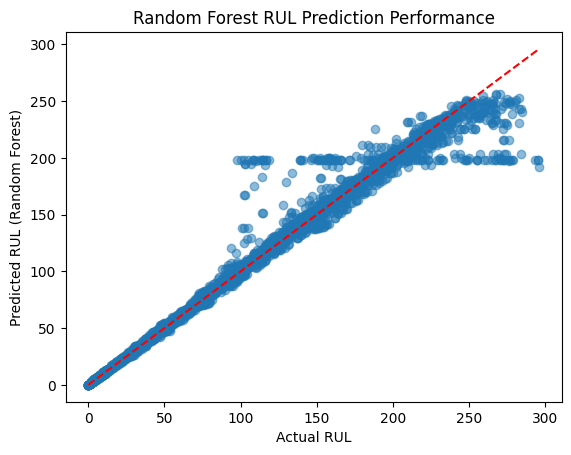

In [9]:
plt.scatter(y_test, y_pred_test_rf, alpha=0.5)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL (Random Forest)")
plt.title("Random Forest RUL Prediction Performance")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()
